In [1]:
# autorelaod
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import transform
from PIL import Image, ImageFont, ImageDraw

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

c:\Users\mo\Documents\Organisations\RUG\rug-hr\experiments
c:\Users\mo\Documents\Organisations\RUG\rug-hr


In [12]:
sample_text = "אל-המערה--אשר בשדה, עפרון החתי.  מט,ל במערה אשר בשדה המכפלה, אשר על-פני-ממרא--בארץ כנען:  אשר קנה א"

In [13]:
#Uses pillow (you can also use another imaging library if you want)

#Load the font and set the font size to 42
font = ImageFont.truetype('./assets/Habbakuk.ttf', 42)

#Character mapping for each of the 27 tokens
char_map = {'Alef' : ')', 
            'Ayin' : '(', 
            'Bet' : 'b', 
            'Dalet' : 'd', 
            'Gimel' : 'g', 
            'He' : 'x', 
            'Het' : 'h', 
            'Kaf' : 'k', 
            'Kaf-final' : '\\', 
            'Lamed' : 'l', 
            'Mem' : '{', 
            'Mem-medial' : 'm', 
            'Nun-final' : '}', # flag
            'Nun-medial' : 'n', 
            'Pe' : 'p', 
            'Pe-final' : 'v', 
            'Qof' : 'q', 
            'Resh' : 'r', 
            'Samekh' : 's', 
            'Shin' : '$', 
            'Taw' : 't', 
            'Tet' : '+', 
            'Tsadi-final' : 'j', 
            'Tsadi-medial' : 'c', # not here
            'Waw' : 'w', 
            'Yod' : 'y', 
            'Zayin' : 'z'}

char2token = {
    "א": "Alef",
    "ב": "Bet",
    "ג": "Gimel",
    "ד": "Dalet",
    "ה": "He",
    "ו": "Waw",
    "ז": "Zayin",
    "ח": "Het",
    "ט": "Tet",
    "י": "Yod",
    "כ": "Kaf",
    "ל": "Lamed",
    "מ": "Mem",
    "נ": "Nun-medial",
    "ס": "Samekh",
    "ע": "Ayin",
    "פ": "Pe",
    "צ": "Tsadi-medial",
    "ק": "Qof",
    "ר": "Resh",
    "ש": "Shin",
    "ת": "Taw",
    "ך": "Kaf-final",
    "ם": "Mem-medial",
    "ן": "Nun-final",
    "ף": "Pe-final",
    "ץ": "Tsadi-final",
}


#Returns a grayscale image based on specified label of img_size
def generate_character(label, img_size):
    if (label not in char_map):
        raise KeyError('Unknown label!')

    #Create blank image and create a draw interface
    img = Image.new('L', img_size, 255)    
    draw = ImageDraw.Draw(img)

    #Get size of the font and draw the token in the center of the blank image
    # w, h = draw.textsize(char_map[label], font=font)
    # get width and height using textbbox
    bb = draw.textbbox((0, 0), char_map[label], font=font)
    w = bb[2] - bb[0]
    h = bb[3] - bb[1]
    draw.text(((img_size[0]-w)/2, (img_size[1]-h)/2), char_map[label], 0, font)

    img = np.array(img)
    img = np.where(img > 0, 1, 0)
    img = 1 - img

    return img

def generate_manuscript_char_img(char, size=(32, 32)):
    token = char2token.get(char, None)
    if (token not in char_map.keys()):
        return None
    
    return generate_character(token, size)

### Loading the dataset
This caches the samples for quick sampling later.

In [14]:
import utils.dataset_preprocessing as ds
cache = ds.cache_char_dataset()

0it [00:00, ?it/s]


FileNotFoundError: [WinError 3] Het systeem kan het opgegeven pad niet vinden: 'datasets\\monkbrill2_processed'

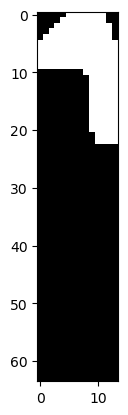

In [6]:
from modules.scripturize.utils.transforms import crop_foreground


def sample_char_img(char, font_size=32, p_fake=0.4):
    img = None
    if np.random.rand() < p_fake:
        img = generate_manuscript_char_img(char, size=(font_size, font_size))
        img = crop_foreground(img, axis=1)
        img = crop_foreground(img, axis=0)
    else:
        img = ds.sample_char(char, cache=cache, height=font_size)
        if img is None:
            return None
        img = img.reshape((1, *img.shape))
        img = img.squeeze(0)
        img = np.mean(img, axis=2)
        img /= 255
        img = 1 - img
        img = img.astype(np.uint8)
    # random rotation
    max_angle = 1
    angle = np.random.randint(-max_angle, max_angle)
    img = transform.rotate(img, angle)

    if char2token[char] in ["Yod"]:
        # char is like an apostrophe, so so we need to pad some white space below it
        h = img.shape[0]
        pad = np.random.randint(int(h * 1.87), int(h*1.95))
        img = np.pad(img, ((0, pad), (0, 0)), mode='constant', constant_values=0)

    # scale down image such that height = font_size
    height, width = img.shape
    aspect_ratio = width / height
    new_height = font_size
    new_width = min(int(aspect_ratio * new_height), font_size)
    img = transform.resize(img, (new_height, new_width),)
    
    img = np.where(img > 0, 1, 0)
    char_index = list(char2token.keys()).index(char) + 1
    img *= char_index
    return img

char = "י"
img = sample_char_img(char, font_size=64)
plt.imshow(img, cmap='gray')
plt.show()


Loaded images from directory: ./assets/scripture_prototypes_fun.
א הנק רשא ןענכ ץראבארממינפלע רשא הלפכמה הדשב רשא הרעמב לטמ יתחה ןורפע הדשב רשאהרעמהלא
Loaded images from directory: ./assets/scripture_prototypes_fun.
א הנק רשא ןענכ ץראבארממינפלע רשא הלפכמה הדשב רשא הרעמב לטמ יתחה ןורפע הדשב רשאהרעמהלא
Loaded images from directory: ./assets/scripture_prototypes_fun.
א הנק רשא ןענכ ץראבארממינפלע רשא הלפכמה הדשב רשא הרעמב לטמ יתחה ןורפע הדשב רשאהרעמהלא
Loaded images from directory: ./assets/scripture_prototypes_fun.
א הנק רשא ןענכ ץראבארממינפלע רשא הלפכמה הדשב רשא הרעמב לטמ יתחה ןורפע הדשב רשאהרעמהלא


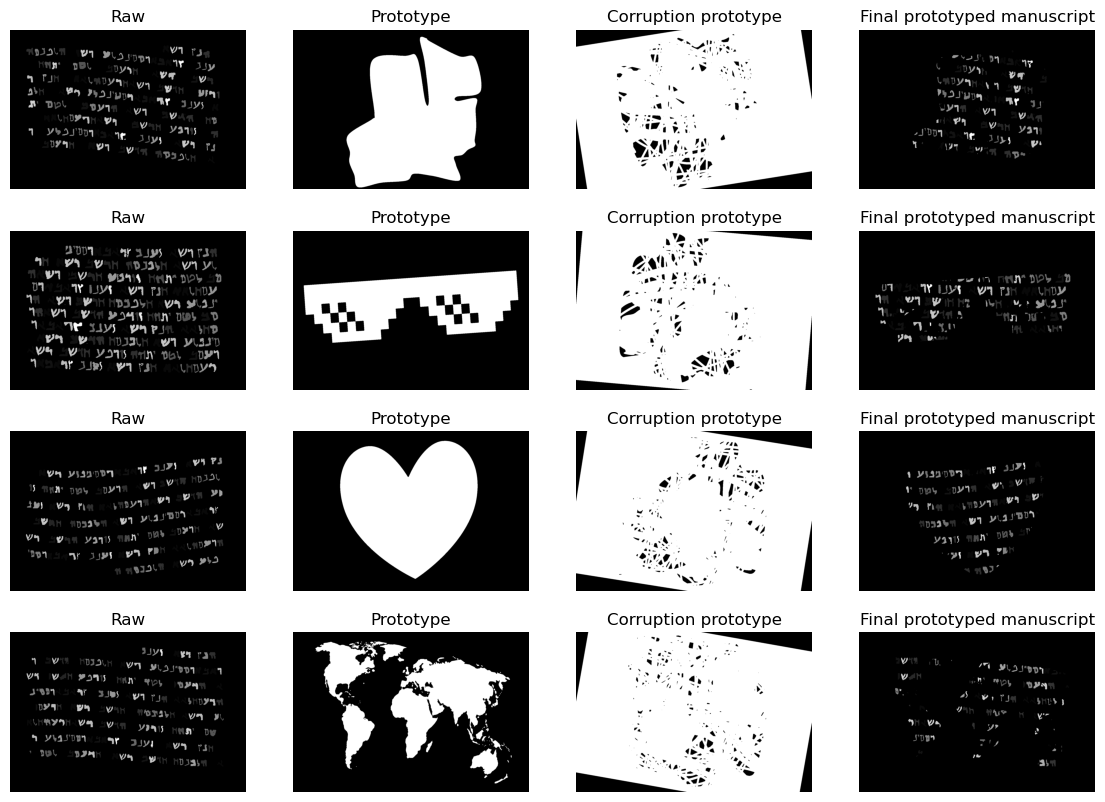

In [14]:
from modules.scripturize import sample_manuscript_from_corpus
from modules.scripturize.utils.plot import show_labelled_manuscript
from modules.scripturize.utils.cache import cache_images

def clean_text(text):
    text = reversed(text)
    allowed_chars = set(char2token.keys())
    allowed_chars.add(' ')
    out = ''.join([c for c in text if c in allowed_chars])
    # do not allow redudntant spaces
    out = ' '.join(out.split())
    return out

corpus = clean_text(sample_text)

NUM_SAMPLES = 4

fig, axes = plt.subplots(NUM_SAMPLES, 4, figsize=(14, 10))
for i in range(NUM_SAMPLES):

    manuscript, params = sample_manuscript_from_corpus(corpus,
        # Scripturize params
        time2token=lambda text, t: text[t % len(text)],
        token2image=lambda token, f: sample_char_img(token, f, p_fake=0.5),
        spacing_token=" ",
        direction=-1,
        size=(1024, 1512),
        allow_intersections=False,
        margin=100, 
        p_corrupt=1,
        p_prototype=1,
        # Sample params
        char_line_shift_range=(16, 64),
        char_spacing_range=(5, 10),
        font_size_range=(32, 64),
        scripture_prototypes_cache=cache_images("./assets/scripture_prototypes_fun")
    )

    print(corpus)

    axes[i, 0].imshow(manuscript['raw'], cmap='gray')
    axes[i, 0].set_title('Raw')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(manuscript['prototype'], cmap='gray')
    axes[i, 1].set_title('Prototype')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(manuscript['corruption_prototype'], cmap='gray')
    axes[i, 2].set_title('Corruption prototype')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(manuscript['mutated'], cmap='gray')
    axes[i, 3].set_title('Final prototyped manuscript')
    axes[i, 3].axis('off')

plt.show()
# save to figures/scriptuizer_prototyping.svg
fig.savefig('figures/scriptuizer_prototyping.pdf', format='pdf', dpi=1200, bbox_inches='tight', pad_inches=0.0)

In [26]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


def sample_text_from_corpus(text_corpus, max_length=8192):
    if len(text_corpus) - max_length < 0:
        return text_corpus
    page = np.random.randint(0, len(text_corpus) - max_length)
    text = text_corpus[page:page+max_length]
    return text


def generate_single_dataset(i, text_corpus, out_dir, file_alias="manu", save=True, *argc, **argv):
    text = sample_text_from_corpus(text_corpus)
    manuscript = None
    while manuscript is None:
        try:
            manuscript, params = sample_manuscript_from_corpus(text, *argc, **argv)
        except Exception as e:
            print(e)
            manuscript = None
    raw_manuscript = manuscript["raw"].astype(np.uint8)
    mutated_manuscript = manuscript["mutated"].astype(np.uint8)

    # Save dataset
    raw_manuscript = Image.fromarray(raw_manuscript)
    mutated_manuscript = Image.fromarray(mutated_manuscript)

    if save:
        raw_manuscript.save(os.path.join(out_dir, "Raw", f"{file_alias}_{i}.png"))
        mutated_manuscript.save(os.path.join(out_dir, "Mutated", f"{file_alias}_{i}.png"))

    return (manuscript, corpus, params)


def generate_manuscript_dataset(
        text_corpus: str, 
        dataset_size=1024, 
        out_dir="./datasets/generated_manuscripts", 
        save=True, 
        parallel=True,
        *argc, **argv):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        os.makedirs(os.path.join(out_dir, "Raw"))
        os.makedirs(os.path.join(out_dir, "Mutated"))
        
    print("MANUSCRIPT GENERATOR :: generating dataset...")
    if parallel:
        with ThreadPoolExecutor() as executor:
            dataset = list(
                tqdm(
                    executor.map(
                        lambda i: generate_single_dataset(i, text_corpus, out_dir, save=save, *argc, **argv),
                        range(dataset_size)
                    ),
                    total=dataset_size,
                )
            )
    else:
        dataset = []
        for i in tqdm(range(dataset_size)):
            dataset.append(generate_single_dataset(i, text_corpus, out_dir, save=save, *argc, **argv))

    return dataset


### Generated datasets

#### Benchmark dataset: No corrputions or prototypes as an unbiased evaluation dataset

No corruptions or added, should be easy for humans

In [ ]:
# Read text from txt file datasets/bible_hebrew_corpus.txt
corpus = None
with open("./datasets/bible_hebrew_corpus.txt", "r") as f:
    corpus = f.read()
    corpus = corpus.replace("\n", " ")

In [29]:
full_corruption_dataset = generate_manuscript_dataset(corpus, 
    # Scripturize params
    time2token=lambda text, t: text[t],
    token2image=lambda token, f: sample_char_img(token, f, p_fake=0.2),
    spacing_token=" ",
    direction=-1,
    size=(1024, 1512),
    allow_intersections=False,
    margin=100, 
    p_corrupt=1,
    p_prototype=1,
    # Sample params
    char_line_shift_range=(16, 64),
    char_spacing_range=(5, 40),
    font_size_range=(32, 64),
    # Generator params
    dataset_size=8192, 
    out_dir="./datasets/dss_corrupted", 
)

MANUSCRIPT GENERATOR :: generating dataset...


 26%|██▌       | 2140/8192 [03:37<10:16,  9.82it/s]


KeyboardInterrupt: 

In [ ]:
main_dataset = generate_manuscript_dataset(corpus, 
    # Scripturize params
    time2token=lambda text, t: text[t],
    token2image=lambda token, f: sample_char_img(token, f, p_fake=0.2),
    spacing_token=" ",
    direction=-1,
    size=(1024, 1512),
    allow_intersections=False,
    margin=100, 
    p_corrupt=0.2,
    p_prototype=0.2,
    # Sample params
    char_line_shift_range=(16, 64),
    char_spacing_range=(5, 40),
    font_size_range=(32, 64),
    # Generator params
    dataset_size=1024, 
    out_dir="./datasets/dss_benchmark", 
)

In [ ]:
benchmark_dataset = generate_manuscript_dataset(corpus, 
    # Scripturize params
    time2token=lambda text, t: text[t],
    token2image=lambda token, f: sample_char_img(token, f, p_fake=0.2),
    spacing_token=" ",
    direction=-1,
    size=(1024, 1512),
    allow_intersections=False,
    margin=100, 
    p_corrupt=0,
    p_prototype=0,
    # Sample params
    char_line_shift_range=(16, 64),
    char_spacing_range=(5, 40),
    font_size_range=(32, 64),
    # Generator params
    dataset_size=1024, 
    out_dir="./datasets/dss_benchmark", 
)

In [ ]:
# Read text from txt file datasets/bible_hebrew_corpus.txt
corpus = None
with open("./datasets/bible_hebrew_corpus.txt", "r") as f:
    corpus = f.read()
    corpus = corpus.replace("\n", " ")

dataset = generate_manuscript_dataset(corpus, 
    dataset_size=2048, 
    margin=100, 
    size=(1024, 1512), 
    allow_intersections=False, 
    out_dir="./datasets/generated_manuscripts_rtl", 
    direction=-1)


### Taking samples

In [ ]:

selection = np.random.randint(0, len(dataset))
dataset_name = "generated_manuscript_dataset"
original = Image.open(f"./datasets/{dataset_name}/Raw/manu_{selection}.png")
manuscript = Image.open(f"./datasets/{dataset_name}/Mutated/manu_{selection}.png")

# convert to numpy array
original = np.array(original)
manuscript = np.array(manuscript)

print(original.shape, manuscript.shape)
print(np.unique(np.array(original)))
print(np.unique(np.array(manuscript)))

# plot the original and mask
size = 15
plt.figure(figsize=(size, size))
plt.subplot(1, 2, 1)
plt.imshow(original, cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(manuscript, cmap="gray")
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './datasets/generated_manuscript_dataset/Images/1205.png'